In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gsp
import seaborn as sns

## Gene set enrichment analysis of H7N9 samples ##

I will just read in the excel files containing two sheets (set 1 and set 2) and look at their enrichments. The tables should have 4 columns:

1. GeneID: HGNC gene symbol
2. GeneDescription: detail name of the gene
3. per OI: sensitivity to oxygen index
4. per LRT: sensitivity to viral titer at lower lung

In [3]:
gene_sets = {gene_set: pd.read_excel('../data/Gene pool_H7N9.xls', sheet_name=gene_set) for gene_set in ['Set 1', 'Set 2']}
gene_sets['Set 1'].head()

,GeneID,GeneDescription,per OI,per LRT
0,CD177,CD177 molecule,-0.013355,0.998697
1,MMP9,matrix metallopeptidase 9,-0.012002,0.888065
2,ALPL,"alkaline phosphatase, liver/bone/kidney",-0.008771,0.673289
3,MGAM,maltase-glucoamylase,-0.009229,0.668396
4,MCEMP1,mast cell-expressed membrane protein 1,-0.008633,0.645316


Lets check if the columns have any correlations

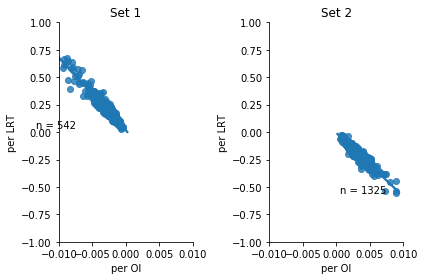

In [4]:
fig = plt.figure()
for i, (gene_set, gs_df) in enumerate(gene_sets.items()):
    ax = fig.add_subplot(1,2,i+1)
    sns.regplot(data = gs_df, x = 'per OI', y = 'per LRT',  ax = ax)
    ax.set_title(gene_set)
    ax.text(gs_df['per OI'].min(), 
            gs_df['per LRT'].min(),  
            'n = %i' %(gs_df.shape[0]))
    ax.set_xlim(-0.01,0.01)
    ax.set_ylim(-1,1)
fig.tight_layout()
sns.despine()

If we look at the scale, seems like they are just pre-filtered gene set, where **set 1** are the positively correlated genes against per LRT, and **set 2** is the opposite.

In this case, I will just combine both dataset for better GSEA.

In [5]:
dfs = []
for gs, gs_df in gene_sets.items():
    dfs.append(gs_df.assign(gs = gs))
df = pd.concat(dfs)
df.head()

,GeneID,GeneDescription,per OI,per LRT,gs
0,CD177,CD177 molecule,-0.013355,0.998697,Set 1
1,MMP9,matrix metallopeptidase 9,-0.012002,0.888065,Set 1
2,ALPL,"alkaline phosphatase, liver/bone/kidney",-0.008771,0.673289,Set 1
3,MGAM,maltase-glucoamylase,-0.009229,0.668396,Set 1
4,MCEMP1,mast cell-expressed membrane protein 1,-0.008633,0.645316,Set 1


In [17]:
gs_df = df.sort_values('per OI')
rnk = gsp.prerank(rnk = gs_df.loc[:, ['GeneID', 'per OI']],
                    gene_sets = 'KEGG_2016',
                    outdir='../GSEA_Prerank/combined' ,format='png') 

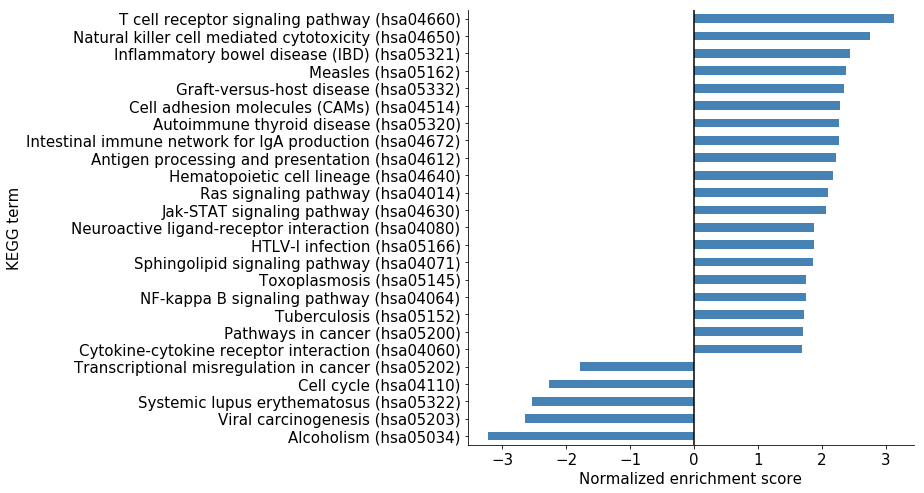

In [26]:
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
rnk\
    .res2d\
    .query('fdr < 0.05')\
    .reset_index()\
    .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
    .sort_values('nes')\
    .plot\
    .barh('Term','nes',
        color = 'steelblue',
        ax = ax)
ax.vlines(x = 0, ymin=-10, ymax=100, color='black')
ax.legend().set_visible(False)
ax.set_ylabel('KEGG term')
ax.set_xlabel('Normalized enrichment score')
#ax.set_yticklabels(ax.get_xticklabels(), rotation=90, ha = 'center')
sns.despine()
figurename = '../figures/combined_kegg_enrichment.png'
fig.savefig(figurename, bbox_inches='tight', transparent = True)

In [19]:
def find_pathway(keyword):
    return [k for k in rnk.results.keys() if keyword in k]

def find_gene(rnk, genes):
    return [i for i, g in enumerate(rnk.ranking.keys()) if g in genes]

In [27]:
def plot_enrichment(kegg_key):
    assert(kegg_key.startswith('hsa'))
    pathway = find_pathway(kegg_key)[0]
    rnk_dict = rnk.results[pathway]
    genes = rnk_dict['genes']
    res = rnk_dict['RES']

    fig = plt.figure(figsize = (8,8))
    es_ax = fig.add_axes([0, 0.5, 1, 0.5])
    gene_ax = fig.add_axes([0,0.45, 1, 0.049])
    heat_ax = fig.add_axes([0, 0.2, 1, 0.45])
    cor_ax = fig.add_axes([0, 0, 1, 0.4])

    xlims = len(res)

    # enrichment plot
    es_ax.plot(res, linewidth=4, color = 'steelblue')
    es_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    es_ax.set_xlim(0, xlims)
    es_ax.xaxis.set_visible(False)
    es_ax.set_ylabel('Running\nEnrichment\nscore')

    # gene plot
    gene_ax.vlines(ymin = 0, ymax = 1, 
               x = find_gene(rnk, genes), 
               color = 'steelblue')
    gene_ax.set_xlim(0, xlims)
    gene_ax.set_yticklabels([])
    gene_ax.xaxis.set_visible(False)
    gene_ax.text(-50, 0.15,'Pathway\ngene', size = 15, ha = 'right')

    # heat cor
    im = heat_ax.imshow([rnk.ranking.values] * 100, cmap = 'viridis')
    heat_ax.xaxis.set_visible(False)
    heat_ax.yaxis.set_visible(False)

    # cor plot
    cor_ax.plot(rnk.ranking.values, 
            color = 'steelblue')
    cor_ax.fill_between(np.arange(0, xlims), 0, rnk.ranking.values)
    cor_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    cor_ax.set_xlim(0, xlims)
    cor_ax.set_ylabel('Sensitivity\nper OI')
    cor_ax.set_xlabel('Gene')
    cor_ax.spines['top'].set_visible(False)

    fig.text(0.5, 1.02, pathway.replace('_Homo sapiens_','\n'), size = 20, ha='center')
    
    figurename = '../figures/' + kegg_key + '.png'
    fig.savefig(figurename, bbox_inches='tight', transparent = True)
    print('Plotted %s' %figurename)

Plotted ../figures/hsa04110.png


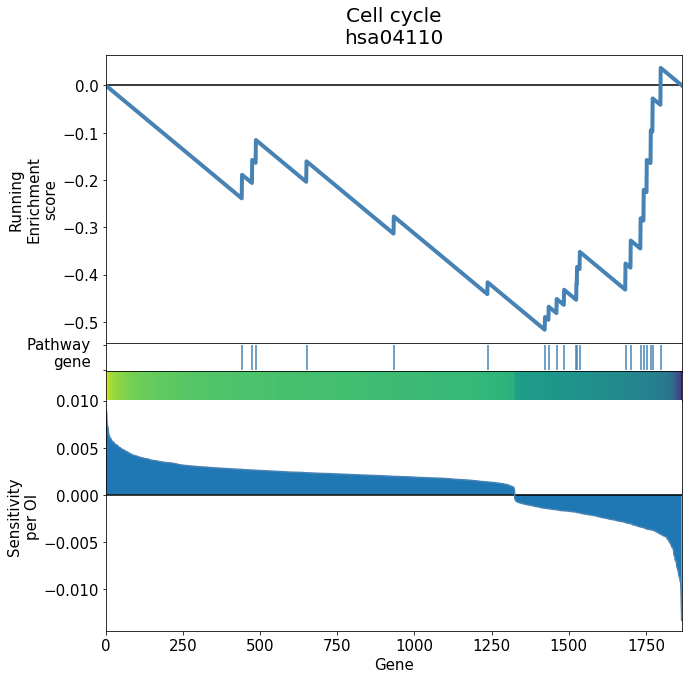

In [28]:
plot_enrichment('hsa04110')

Plotted ../figures/hsa04660.png


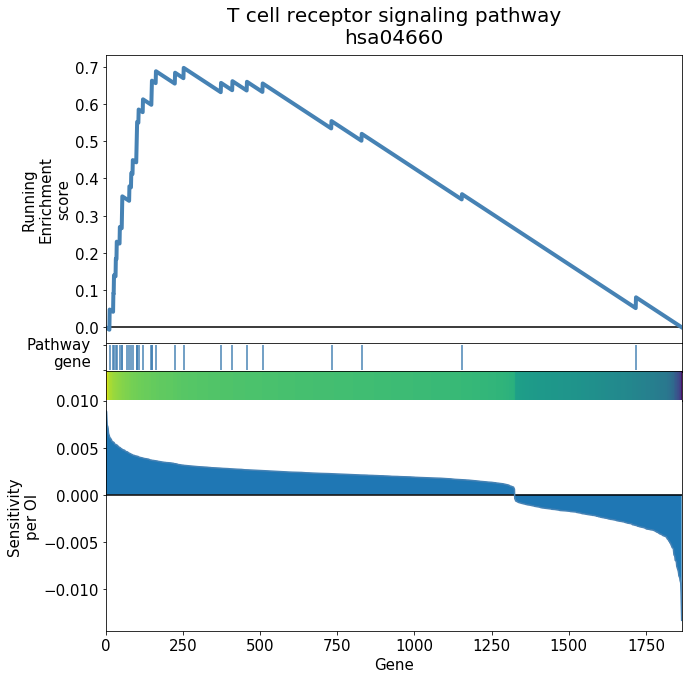

In [29]:
plot_enrichment('hsa04660')